# CNN Tabanlı Görüntü Sınıflandırma Projesi

**Adınız:** Eftalya Beril  
**Soyadınız:** ŞAHİN  
**Okul Numaranız:** 2212721037  
**GitHub Repo Bağlantısı:** https://github.com/kullanici_adi/CNN_siniflandirma

## Model 3 – Basit ve Kararlı (Stable) CNN Modeli

Model 3, daha karmaşık mimarilerden kaçınılarak oluşturulmuş,
**basit ama kararlı** bir Convolutional Neural Network (CNN) yapısına sahiptir.

Bu modelin amacı:
- Eğitim sürecinde çökme yaşamamak
- Daha stabil bir öğrenme davranışı sergilemek
- Temel CNN yaklaşımının performansını gözlemlemektir

### Reproducibility (Tekrarlanabilirlik)

Model 3’te eğitim sonuçlarının tutarlı olması için
`random`, `numpy` ve `tensorflow` için sabit bir **seed (42)** değeri kullanılmıştır.

Bu sayede:
- Aynı kod tekrar çalıştırıldığında benzer sonuçlar elde edilir
- Eğitim süreci daha kontrollü ve analiz edilebilir hale gelir

### Veri Ön İşleme (Minimal Augmentation)

Bu modelde veri artırma işlemleri minimum seviyede tutulmuştur.
Sadece:
- Görüntülerin 0–1 aralığına normalize edilmesi
- Yatay çevirme (horizontal flip)

uygulanmıştır.

Amaç, aşırı veri artırmanın model üzerindeki etkisini azaltarak,
modelin ham veri üzerinden nasıl öğrendiğini gözlemlemektir.

### Veri Seti Dağılımının Analizi

Model eğitilmeden önce:
- Eğitim
- Doğrulama
- Test

veri setlerindeki sınıf dağılımları ekrana yazdırılmıştır.

Bu adım, sınıflar arasında dengesizlik olup olmadığını kontrol etmek
ve model performansını daha doğru yorumlamak açısından oldukça önemlidir.

### Model Mimarisi – Genel Yapı

Model 3, klasik CNN mimarisine uygun olarak tasarlanmıştır:

- 3 adet Conv2D + MaxPooling bloğu
- Ardından Flatten ve Dense katmanları
- Softmax çıkış katmanı

Bu yapı, CNN’lerin temel çalışma mantığını net bir şekilde yansıtmaktadır.

### Katman Yapısının Detayları

Modelde kullanılan konvolüsyon katmanları sırasıyla:
- 32 filtre
- 64 filtre
- 128 filtre

şeklinde ilerlemektedir.

Bu sayede model, görüntülerdeki basit özelliklerden başlayarak
daha karmaşık yapıları öğrenebilmektedir.

### Modelin Derlenmesi

Model aşağıdaki ayarlarla derlenmiştir:
- **Optimizer:** Adam
- **Learning Rate:** 0.0001
- **Loss Function:** Categorical Crossentropy
- **Metric:** Accuracy

Düşük öğrenme oranı tercih edilerek,
modelin daha stabil ve kontrollü öğrenmesi hedeflenmiştir.

### Eğitim Süreci

Model 3’te eğitim süreci boyunca herhangi bir erken durdurma (EarlyStopping)
veya öğrenme oranı azaltma (ReduceLROnPlateau) kullanılmamıştır.

Bu bilinçli bir tercihtir:
- Modelin belirlenen epoch sayısı boyunca eğitilmesi sağlanmıştır
- Eğitim davranışı kesintisiz olarak gözlemlenmiştir

### Test Süreci ve Performans Analizi

Eğitim tamamlandıktan sonra model,
daha önce hiç görmediği test verileri üzerinde değerlendirilmiştir.

Değerlendirme aşamasında:
- Test accuracy
- Confusion matrix
- Classification report (precision, recall, f1-score)

hesaplanarak modelin sınıflandırma başarısı detaylı şekilde incelenmiştir.

### Model 3 Genel Değerlendirme

Model 3, karmaşık teknikler kullanılmadan oluşturulmuş,
temel bir CNN yaklaşımını temsil etmektedir.

Bu model:
- Basitliği sayesinde kararlı bir eğitim süreci sunar
- Daha gelişmiş modellerle karşılaştırma yapmak için iyi bir referans noktasıdır


In [5]:
import random
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report

# =================================================
# SEED
# =================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# =================================================
# PARAMS
# =================================================
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 30
DATA_DIR = "../dataset"

# =================================================
# DATA (MINIMAL AUGMENTATION)
# =================================================
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
).flow_from_directory(
    DATA_DIR + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    DATA_DIR + "/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    DATA_DIR + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes

# =================================================
# PRINT DATASET INFO (ÇOK ÖNEMLİ)
# =================================================
print("Class indices:", train_gen.class_indices)
print("Train distribution:", np.bincount(train_gen.classes))
print("Val distribution:", np.bincount(val_gen.classes))
print("Test distribution:", np.bincount(test_gen.classes))

# =================================================
# SIMPLE BUT STRONG MODEL
# =================================================
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# =================================================
# TRAIN (ASLA DURMAZ)
# =================================================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# =================================================
# TEST
# =================================================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print("\nTEST ACCURACY:", test_acc)

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))


Found 84 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Class indices: {'canta': 0, 'cuzdan': 1}
Train distribution: [48 36]
Val distribution: [16 12]
Test distribution: [11 11]
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 570ms/step - accuracy: 0.5000 - loss: 0.6940 - val_accuracy: 0.5714 - val_loss: 0.6753
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.5714 - loss: 0.6504 - val_accuracy: 0.5714 - val_loss: 0.6640
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.5714 - loss: 0.6189 - val_accuracy: 0.5714 - val_loss: 0.6631
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.5833 - loss: 0.5807 - val_accuracy: 0.5714 - val_loss: 0.6425
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.8333 - loss: 0.5324 - val_accuracy: 0.5714 - val_loss: 0.6340
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 0.8452 - loss: 0.4813 - val_accuracy: 0.5714 - val_loss: 0.6071
Ep

In [7]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print("\nTEST ACCURACY:", test_acc)

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))


TEST ACCURACY: 0.9090909361839294
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step

Confusion Matrix:
[[11  0]
 [ 2  9]]

Classification Report:
              precision    recall  f1-score   support

       canta       0.85      1.00      0.92        11
      cuzdan       1.00      0.82      0.90        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22



MODEL KATMAN TABLOSU


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,914,696 (37.82 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,798 (25.21 MB)

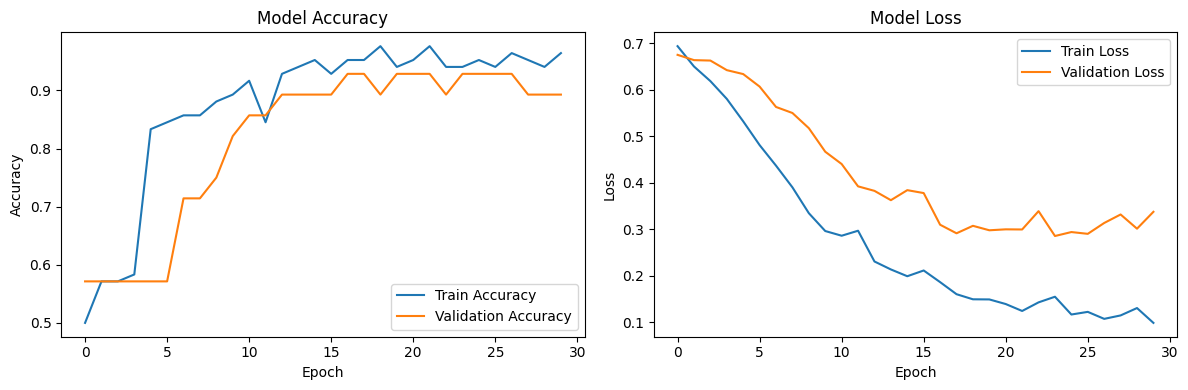

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step

Confusion Matrix:


,canta,cuzdan
canta,11,0
cuzdan,2,9



Classification Report:
              precision    recall  f1-score   support

       canta       0.85      1.00      0.92        11
      cuzdan       1.00      0.82      0.90        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22


FINAL Test Accuracy: 0.9091


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ======================
# MODEL ÖZETİ
# ======================
print("MODEL KATMAN TABLOSU")
model.summary()

# ======================
# EĞİTİM GRAFİKLERİ
# ======================
plt.figure(figsize=(12, 4))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ======================
# TEST TAHMİNLERİ
# ======================
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# ======================
# CONFUSION MATRIX (TABLO)
# ======================
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

print("\nConfusion Matrix:")
display(cm_df)

# ======================
# CLASSIFICATION REPORT
# ======================
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

# ======================
# TEST ACCURACY
# ======================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"\nFINAL Test Accuracy: {test_acc:.4f}")
